This script can be used to analyze the following burst parameters:
* Intra-burst frequency (Spikes/s = Hz)
* Mean burst length (s)
* Mean bursts/cell/s (/cell/s)

For usage, the <i>filename</i> variable must be changed accordingly. <br>
The <i>pdf_out_filename</i> variable sets the pdf output filename.<br>
<br>
As is, the display only differentiates between angiotensin-II concentrations. Please change accordingly if other or more parameters shall be investigated.<br>
<br>
If the expected burst parameters are changed from WT, <i>maxEventLength</i> (determines the allowed distance between bursts) and <i>minEventInCluster</i> (sets the minimum number of spikes per burst) of the <i>getBursts()</i> function should be adjusted.

<i>Version: 20211105_1_GS</i>

In [4]:
import calim
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from matplotlib.backends.backend_pdf import PdfPages


In [7]:
# Change filename as needed:
filename = "C:/Users/gabri/Downloads/Cal520AM_Osmo_312_MV_211127.hdf"


pdf_out_filename = "Burst_Analysis.pdf"


if filename[-4:].lower() == ".pkl":
    data = pickle.load(open(filename, "rb"))
elif filename[-4:].lower() == ".hdf":
    data = calim.Project()
    data.from_hdf(filename)


In [8]:
def getBursts(eventList, dt=0.1, maxEventLength=5, minEventInCluster=3):
        
    maxEventLength=maxEventLength/dt # Convert the maxEventLength into number of frames
    burstFrequency=pd.DataFrame([])
    
    if len(eventList) <= 0:
        return burstFrequency   

    eventList = np.array([e.frame for e in eventList if e.use])
    
    last = eventList[0]
    cluster = np.array([])
    n_bursts = 0

    for i in eventList[1:]:
        if i - last <= maxEventLength:
            if len(cluster) == 0:
                cluster = np.append(cluster, last)
            cluster = np.append(cluster,i)
            #print(i)
        else:
            if len(cluster)>= minEventInCluster:
                #print("cluster ende", cluster)
                meanFreq = 1 / (np.mean(np.diff(cluster))*dt)
                lenEvents = len(cluster)
                length = (cluster[-1] - cluster[0])*dt
                n_bursts += 1
                d = pd.DataFrame(data={"burst_freq": [meanFreq], \
                                       "burst_num_spikes":[lenEvents], "burst_length":[length], "burst_n":[n_bursts],\
                                       "first_frame":[cluster[0]],\
                                      "last_frame":[cluster[-1]]})   
                burstFrequency = pd.concat([burstFrequency, d])


                #print(meanFreq, lenEvents, length, n_bursts)

            cluster = np.array([])
        last = i
        
    if len(cluster) >= minEventInCluster:
        meanFreq = 1 / (np.mean(np.diff(cluster))*dt)
        lenEvents = len(cluster)
        length = (cluster[-1] - cluster[0])*dt
        n_bursts += 1
        d = pd.DataFrame(data={"burst_freq": [meanFreq], \
                               "burst_num_spikes":[lenEvents], "burst_length":[length], "burst_n":[n_bursts],\
                               "first_frame":[cluster[0]],\
                              "last_frame":[cluster[-1]]})   
        burstFrequency = pd.concat([burstFrequency, d])
    burstFrequency["burst_n"] = n_bursts
    return burstFrequency

In [9]:
# The DataFrame "data" will contain all burst information about conditions
burst_data = pd.DataFrame()
print(f"Processing recordings contained in {filename}:")
for recording in data.recordings:
    print(recording)
    
    r = data.recordings[recording]

    # Read information for the recording to be added to the final table
    info = {desc: r.information[desc] for desc in r.information}
    
    for cell in r.cells:
        c = r.cells[cell]
        if c.use: # Only include if the cell is supposed to be used
            for con in r.conditions: # Iterate over conditions
                info["recording"] = recording
                info["start"] = int(con.start)
                info["end"] = int(con.end)
                info["cell"] = cell
                info["dt"] = r.dt # Add "dt" aka seconds/frame
                info.update({desc: con.information[desc] for desc in con.information}) # Add all further condition variables
                for i, row in getBursts(list(c.get_event(range(info["start"], info["end"]))), dt=r.dt).iterrows():
                    # Append one row for every burst:
                    burst_data = burst_data.append(row.append(pd.Series(info)), ignore_index=True)

# Convert the "burst_n" column from bursts/cell to bursts/cell/second
burst_data["burst_n"] = burst_data["burst_n"]/((burst_data["end"]-burst_data["start"])*burst_data["dt"])
print("Done")

Processing recordings contained in C:/Users/gabri/Downloads/Cal520AM_Osmo_312_MV_211127.hdf:
210916_Slice2_Rec1.csv
210916_Slice3_Rec1.csv
210916_Slice4_Rec1.csv
210916_Slice_1_Rec_1.csv
210921_Slice_1_Rec_1.csv
210921_Slice_2_Rec_1.csv
210921_Slice_3_Rec_1.csv
210921_Slice_4_Rec_1.csv
210923_Slice_1_Rec_1.csv
210923_Slice_2_Rec_1.csv
210923_Slice_3_Rec_1.csv
210923_Slice_4_Rec_1.csv
210923_Slice_5_Rec_1.csv
210927_Slice_1_Rec_1.csv
210927_Slice_2_Rec_1.csv
210927_Slice_3_Rec_1.csv
210927_Slice_4_Rec_1.csv
Done


In [10]:
burst_data.describe()

,burst_freq,burst_length,burst_n,burst_num_spikes,dt,end,first_frame,last_frame,start
count,1501.000000,1501.000000,1501.000000,1501.000000,1.501000e+03,1501.000000,1501.000000,1501.000000,1501.000000
mean,1.068811,70.202798,0.006860,85.996003,1.000000e-01,11693.471019,7753.437708,8455.465690,5142.418388
std,0.351496,85.124834,0.004397,127.687577,2.776483e-17,6432.079032,5579.117533,5524.620568,4032.515484
min,0.229885,1.200000,0.001130,3.000000,1.000000e-01,3150.000000,1.000000,46.000000,0.000000
25%,0.828025,20.100000,0.003390,19.000000,1.000000e-01,3250.000000,2662.000000,3146.000000,0.000000
50%,1.057692,45.800000,0.006250,49.000000,1.000000e-01,9150.000000,8005.000000,9141.000000,3251.000000
75%,1.278772,90.000000,0.009041,107.000000,1.000000e-01,18000.000000,12655.000000,13199.000000,9151.000000
max,2.274678,737.600000,0.031746,1286.000000,1.000000e-01,18000.000000,17924.000000,17999.000000,9651.000000


<Figure size 432x288 with 0 Axes>

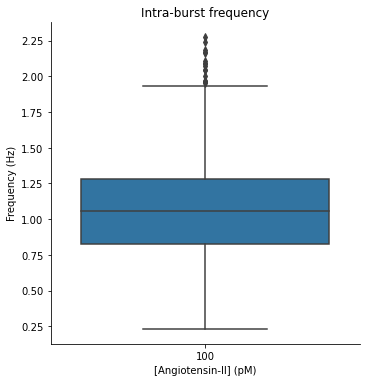

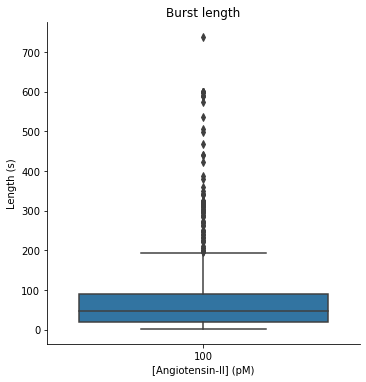

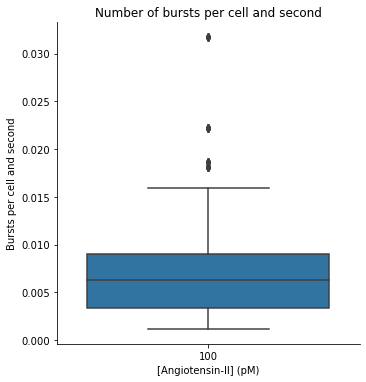

In [13]:
# Please change the display as needed!

show_individual_cells = False

with PdfPages(pdf_out_filename) as pdf:

    plt.figure()
    sns.catplot(x="angiotensin", y="burst_freq", data=burst_data, kind="box")
    plt.title("Intra-burst frequency")
    plt.xlabel("[Angiotensin-II] (pM)")
    plt.ylabel("Frequency (Hz)")
    pdf.savefig()
    
    sns.catplot(x="angiotensin", y="burst_length", data=burst_data, kind="box")
    plt.title("Burst length")
    plt.xlabel("[Angiotensin-II] (pM)")
    plt.ylabel("Length (s)")
    pdf.savefig()
    
    n_data = burst_data.groupby(["angiotensin", "recording", "cell"]).mean().reset_index()
    sns.catplot(x="angiotensin", y="burst_n", data=burst_data, kind="box")
    plt.title("Number of bursts per cell and second")
    plt.xlabel("[Angiotensin-II] (pM)")
    plt.ylabel("Bursts per cell and second")
    
    pdf.savefig()
    
    if show_individual_cells:
        sns.catplot(x="angiotensin", y="burst_freq", hue="cell", col="recording", data=burst_data, aspect=0.5)
        pdf.savefig()

        sns.catplot(x="angiotensin", y="burst_length", hue="cell", col="recording", data=burst_data, aspect=0.5)
        pdf.savefig()

        sns.catplot(x="angiotensin", y="burst_n", hue="cell", col="recording", data=burst_data, aspect=0.5)
        pdf.savefig()
    